# Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from icap.database.icapdatabase import ICapDatabase
from icap.results.results import Results

In [2]:
fp = 'icap/database/icapdatabase.json'
conn = ICapDatabase(fp).connect()

if conn.__class__.__name__ != 'Connection':
    raise Exception('No Connection')

In [3]:
def comparision(*tuples):
    """Provides quick comparisons between recipe and available test cases
    
    @input [(param_id, recipe_val, testcase_val), ...]
    @return None
    """
    print('{0:^60}'.format('Recipe vs TestCase Comparision\n'))
    print('               {0:<15} {1:<15} {2:<15}'.format('Recipe', 'TestCase', 'Varinace %'))
    for tup in tuples:
        try:
            var = (tup[1] - tup[2]) / tup[1] * 100.
        except ZeroDivisionError:
            var = 0
        finally:
            print( '{0!s:<15} {1!s:<15} {2!s:<15} {3!s:<15}'.format( tup[0], tup[1], tup[2], var ))

# CONED 

In [4]:
from icap.coned.coned import CONEDMonthly

In [4]:
# premises and error
prems_to_inspect = np.array([
    ['494201000700002','low_variance_1.1%'],
    ['544582782020002','zero_icap'],
    ['677606742000009','zero_icap'],
    ['233774551600009','zero_icap'],
    ['700536121000000','cons_not_dmd']
])

In [5]:
cm = CONEDMonthly(conn)
cm.compute_mcd()

In [6]:
# compute

for prem in prems_to_inspect[:, 0]:
    print('*' * 79)
    print('Premise Id: %s\n' % prem)
    val = cm.monthly.xs((prem, 2015), level=0).ix[0]
    print(val, '\n')

*******************************************************************************
Premise Id: 494201000700002

RateClass                9
Strata               351.3
ZoneCode                 J
Stratum              366.7
TOD                     50
StartDate       2015-06-02
EndDate         2015-07-30
BilledUsage         116200
BilledDemand           394
MeterType              DMD
MCD                108.483
NormUsage          108.483
MeterLogic             DMD
MeterRegex            [^T]
Name: (494201000700002, 2015), dtype: object 

*******************************************************************************
Premise Id: 544582782020002

RateClass                1
Strata               67641
ZoneCode                 I
Stratum              71091
TOD                     53
StartDate       2015-07-02
EndDate         2015-07-31
BilledUsage           5675
BilledDemand           inf
MeterType              CON
MCD                  False
NormUsage            False
MeterLogic            VTOU
MeterR

## Premise `494201000700002`

In [7]:
compar_vals = [
    ('Billed Demand', 394, 394), 
    ('AMR Bill Cycle', 116200, 116200), 
    ('TOU', False, False),
    ('Stratum', 366.7, 329.5),
    ('MCD', 108.483, 243.5523)
]

In [8]:
comparision(*compar_vals)

NameError: name 'comparision' is not defined

### Analysis

**Stratum** values differ. `LoadProfile` depends upon `Stratum`. This difference between test case and database results in two distinct load profile values. Downstream calculations build on the selected MCD value.
```python
# MCD Logic for non-interval CONED
if metertype == 'DMD':
    mcd = np.min([normalized_usage, billed_demand])
else:
    mcd = normalized_usage
```

### Load shape comparison against bill cycle

In [77]:
meta = cm.monthly.xs((prems_to_inspect[1,0], 2015))
meta

,,RateClass,Strata,ZoneCode,Stratum,TOD,StartDate,EndDate,BilledUsage,BilledDemand,MeterType,MCD,NormUsage,MeterLogic,MeterRegex
PremiseId,Year,,,,,,,,,,,,,,
544582782020002,2015,1,67641,I,71091,53,2015-07-02,2015-07-31,5675.0,inf,CON,False,False,VTOU,T


In [68]:
meta = cm.monthly.xs((prems_to_inspect[1,0], 2015))

stratum, rate_class, zone, billstart, billend, billdemand, meter_regex = meta[
    ['Stratum', 'RateClass', 'ZoneCode', 'StartDate', 'EndDate', 'BilledDemand','MeterRegex']].values[0]
stratum = np.float32(stratum)
rate_class = np.int32(rate_class)

print('STRATUM: ', stratum)
print('RATE CLASS: ', rate_class)
print('ZONE: ', zone)
print('METER Regex: ', meter_regex, '\n')

local_lst = pd.merge(cm.temp_var.ix[billstart:billend], cm.lst,
        left_index=True, right_index=True,
        on=['Max', 'DayOfWeek'])

print('\tAfter JOIN ', np.unique(local_lst['SC'].values))

stratum_lower_mask = local_lst['STRAT L BOUND'] <= stratum
stratum_upper_mask = local_lst['STRAT U BOUND'] > stratum
stratum_mask = (stratum_lower_mask == 1) & (
    stratum_upper_mask == 1)
local_lst = local_lst.ix[stratum_mask]
print('Load Shape Dims after STRATUM filter: ', local_lst.shape)
print('\tAfter STRATUM ', np.unique(local_lst['SC'].values))


# Filter for TimeOfDay meter type and Service Class Mapping
tod_mask = local_lst['STRATA'].str.contains(meter_regex)

local_lst = local_lst[tod_mask]
print('Load Shape Dims after TOD filter: ', local_lst.shape)
print('\tAfter TOD ', np.unique(local_lst['SC'].values))

sc_mask = (local_lst['SC'] == cm.rc_map.ix[rate_class]['Map'])

print('\tRate Class: ', rate_class)
print('\tMapping: ', cm.rc_map.ix[rate_class]['Map'])

local_lst = local_lst[sc_mask]
print('Load Shape Dims after SC Mask: ', local_lst.shape)
print('\tAfter SC ', np.unique(local_lst['SC'].values))


#mask = (tod_mask == 1) & (sc_mask == 1)
#local_lst = local_lst.ix[mask]



print(cm.temp_var.ix[billstart:billend].shape)

print(local_lst.shape)

STRATUM:  71091.0
RATE CLASS:  1
ZONE:  I
METER Regex:  T 

	After JOIN  [ 1  2  5  6  7  8  9 12 13 51 62 65 66 68 69 80 82 85 91 93 98]
Load Shape Dims after STRATUM filter:  (2040, 35)
	After STRATUM  [ 1  2  5  6  7  8  9 12 13 51 62 65 66 68 69 80 82 85 91 93 98]
Load Shape Dims after TOD filter:  (300, 35)
	After TOD  [ 5  8  9 12 13 68 69 91 93 98]
	Rate Class:  1
	Mapping:  1
Load Shape Dims after SC Mask:  (0, 35)
	After SC  []
(30, 2)
(0, 35)


In [76]:
cm.rc_map.sort_index()

,Map,TODQ
RateClass,,
1,1,0
2,2,0
7,7,1
8,8,0
9,9,0
12,12,1
21,1,0
29,9,0
37,7,0


## Premise `700536121000000`

In [10]:

compar_vals = [
    ('Billed Deamnd', 0, 0), 
    ('AMR Bill Cycle', 172, 172), 
    ('TOU', False, False),
    ('Stratum', 403, 403),
    ('MCD', 0.260391, 0.25935)
]
comparision(*compar_vals)

              Recipe vs TestCase Comparision
               
               Recipe          TestCase        Varinace %     
Billed Deamnd   0               0               0              
AMR Bill Cycle  172             172             0.0            
TOU             False           False           0              
Stratum         403             403             0.0            
MCD             0.260391        0.25935         0.39978340265214957


### Analysis

**Why demand is selected versus consumption?**<br>
The _DEMAND_ returned from the SQL query is not `NULL`. Any premise with a non-`NULL` value for demand is considered a demand meter. The SQL snippet is provided below.

```sql
--SQL Select for Monthly records
...
iif(m.Demand is null, 'CON','DMD') as MeterType
...
```

# MCD Values Zeoring Calculations 

### Assignment of MCD based on filtering criteria

Why would MCD values be returned assigned  to `False`? This is a result of a comparision filter. The filter compares the row count `local_load_shape_table` to number of days in the premise `bill_cycle`. If the number of days are not matching, the `normalized_usage` cannot be computed correctly.

```python
# Loadshape filter
if local_load_shape_num_rows != billcycle_num_rows:
    # update the premise-year record
    monthly.loc[
        (premise, year),       # index 
        ['NormUsage', 'MCD']   # columns to update
    ] = False 
```

### Percentage of total assigned as `False`

What percentage of the total records are assigned `False` for MCD ? **7.7%**

In [60]:
total_records = cm.monthly['MCD'].shape[0]
droped_na = cm.monthly['MCD'].dropna().shape[0]
mcd_false = cm.monthly[cm.monthly['MCD'] == False].shape[0]

print('Total Records: %d' % total_records)
print('Records without NaN Values in MCD: %d\t Percent of Total: %2.3f' %(droped_na, 1.0 - droped_na / total_records))
print('MCD == False Records: %d\t Percent of Total %2.3f' % (mcd_false, mcd_false/ total_records))

Total Records: 20701
Records without NaN Values in MCD: 20690	 Percent of Total: 0.001
MCD == False Records: 1590	 Percent of Total 0.077


### Similarities

What information is available that may provide further insight?
1. Annual Trends
2. Rate Class Dependence
3. Zone Code
4. MeterType

In [69]:
# extract the records of interests
rec_of_interest = cm.monthly[cm.monthly['MCD'] == False].reset_index()

In [71]:
rec_of_interest[['RateClass', 'MeterRegex']]

,RateClass,MeterRegex
0,9,[^T]
1,7,[^T]
2,9,[^T]
3,9,[^T]
4,51,[^T]
5,116,T
6,116,T
7,901,[^T]
8,901,[^T]
9,1,[^T]


In [13]:
# n-year history per premise
from collections import defaultdict
d = defaultdict(int)

for prem in rec_of_interest['PremiseId'].values:
    d[prem] += 1

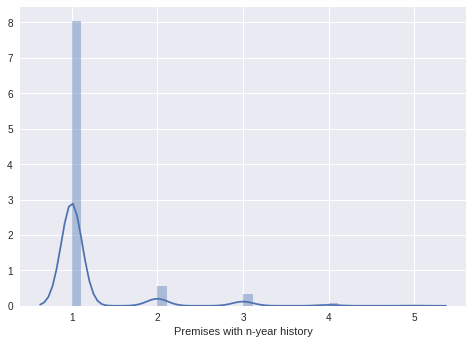

In [31]:
# Histplot
fig, ax = plt.subplots(1,1)

counts = list(d.values())
sns.distplot(counts, norm_hist=False, ax=ax, axlabel="Premises with n-year history");

The majority of premises avaialbe only have a single year of history. 

## Distribution of Zone Codes 

What effect, if any, does the zone code have on successful completion of MCD calculation? 

In [81]:
zone1 = defaultdict(float)
zone1_rows = cm.monthly[cm.monthly['MCD'] >= 0.].shape[0]
for zone_code in cm.monthly[cm.monthly['MCD'] >= 0.]['ZoneCode'].values:
    
    zone1[zone_code] += 1 / zone1_rows

zone2 = defaultdict(float)
zone2_rows = rec_of_interest.shape[0]
for zone_code in rec_of_interest['ZoneCode'].values:
    zone2[zone_code] += 1 / zone2_rows

In [88]:
print('Numeric MCD Zone Distribution\n\t',dict(zone1), '\n')
print('Non-numeric MCD Zone Distribution\n\t', dict(zone2))

Numeric MCD Zone Distribution
	 {'J': 0.8662155630741348, 'H': 0.02334461092315143, 'I': 0.11043982600289547} 

Non-numeric MCD Zone Distribution
	 {'J': 0.8213836477987421, 'H': 0.0490566037735849, 'I': 0.12955974842767295}


The zone code distribution between numeric and non-numeric results appear to be **uniformly distributed**. 

## Distribtution of Stratum Values

Similar to zone codes, the stratum values will be inspected to determine if their distribtuion of values provides indication to non-numeric results.

(-10000, 100000)

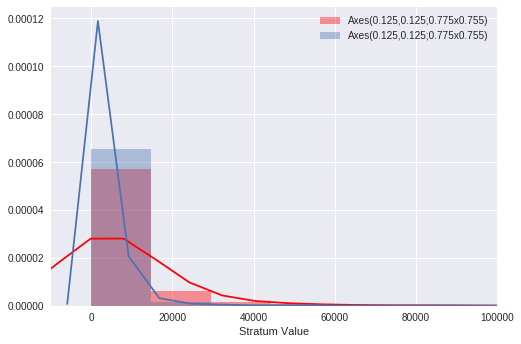

In [94]:
fig, ax = plt.subplots(1,1)

false_vals = sns.distplot(rec_of_interest['Stratum'].values, axlabel='Stratum Value', ax=ax, color='red', label='False');
numeric_vals = sns.distplot(cm.monthly[cm.monthly['MCD'] >= 0.]['Stratum'].apply(np.float32), axlabel='Stratum Value', ax=ax, label='Numeric');

#plt.legend(labels=[false_vals, numeric_vals])
ax.legend(labels=[false_vals, numeric_vals])
plt.xlim([-10000, 100000])

### Inspection of Stratum Values <= 40,000

In [105]:
# MCD == False
roi = rec_of_interest[rec_of_interest['Stratum'] <= 40000.]['Stratum']

print('Max Stratum of 40,000')
print('Total Non-numeric records: ', rec_of_interest.shape[0])
print('Total Non-numeric records Stratum <= 40,000 :', roi.shape[0])
print('Percentage represented: %.3f' % (roi.shape[0] / rec_of_interest.shape[0]))

Max Stratum of 40,000
Total Non-numeric records:  1590
Total Non-numeric records Stratum <= 40,000 : 1515
Percentage represented: 0.953


In [118]:
# MCD != False
numeric = cm.monthly[cm.monthly['MCD'] != False]['Stratum'].apply(np.float32)
noi = numeric[numeric <= 40000]

print('Max Stratum of 40,000')
print('Numeric records: ', numeric.shape[0])
print('Numeric records Stratum <= 40,000:', noi.shape[0])
print('Percentage represented: %.3f' % (noi.shape[0] / numeric.shape[0]))


Max Stratum of 40,000
Numeric records:  19111
Numeric records Stratum <= 40,000: 19024
Percentage represented: 0.995


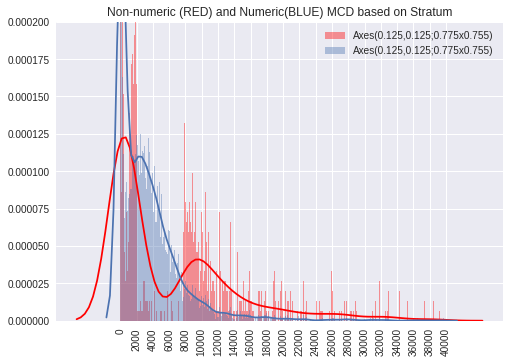

In [156]:
# Plotting the condensed ranges
fig, ax = plt.subplots(1,1)

nn = sns.distplot(roi.values, bins=bins, color='red', ax=ax, label='Non-Numeric') 
num = sns.distplot(noi.values, bins=bins, ax=ax, label='Numeric')

bins = np.arange(0, 40001, 100)
plt.ylim([0, 0.0002]);
plt.legend(labels=[nn, num]);
plt.xticks(np.arange(0, 40001, 2000), rotation='vertical');

plt.title('Non-numeric (RED) and Numeric(BLUE) MCD based on Stratum');
plt.show()

Based on the above distributions, when `Stratum` values are larger than 8000, there is a spike in recipe failures.

### Stratum Values Greater than 8000

In [152]:
stratum = cm.monthly['Stratum'].apply(np.float32).values

large_stratum = cm.monthly.ix[np.where(stratum >= 8000)[0]]
non_numeric = large_stratum[large_stratum['MCD'] == False]
numeric = large_stratum[large_stratum['MCD'] != False]

# Updated Run Analysis

In [7]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [49]:
def peek(filepath):
    df = pd.read_csv(filepath)
    print('*' * 79)
    print(filepath.split('/')[-1],'\n')
    # RecipeICap, HistoricalICap, RecipeVariance
    # Count original records
    orig_rows = df.shape[0]

    # Drop where variance is NaN
    scrubbed = df.dropna(subset=['RecipeVariance'])
    scrubbed_rows = scrubbed.shape[0]

    print('Original Samples: {}'.format(orig_rows))
    print('Scrubbed Samples: {}'.format(scrubbed_rows))
    print('Remaining Information: {:.3}'.format(scrubbed_rows / orig_rows))
    hicap = df['HistoricalICap']
    
    percent_mask = scrubbed['RecipeVariance'] <= 2
    kw_mask = abs(scrubbed['RecipeICap'] - scrubbed['HistoricalICap']) <= 1

    scrubbed_filtered = scrubbed[(percent_mask == 1) | (kw_mask == 1)]
    
    grp = df[df['RecipeICap'] == 0.].groupby(['Year', 'MeterType']).size()

    print('Scrubbed Samples: {}\n'.format(scrubbed_rows))
    print('Scrubbed ROWS PERCENT Mask: {}'.format(scrubbed[percent_mask].shape[0]))
    print('Scrubbed Percent passing 2% Variance: {:.3}\n'.format(scrubbed[percent_mask].shape[0] / scrubbed_rows))
    print('Scrubbed 1 KW Mask: {}'.format(scrubbed[kw_mask].shape[0]))
    print('Scrubbed Percent passing 1kW: {:.3}\n'.format(scrubbed[kw_mask].shape[0] / scrubbed_rows))
    print('Samples Passing 2% Var AND 1kW: {:.3}\n'.format(scrubbed_filtered.shape[0] / scrubbed_rows))

    print('Historical ICap: {}'.format(hicap.shape))

    print('NaN Values as percent of total: {}'.format(np.mean(hicap.isnull())))
    print('HistoricalICap == 0 percent of total: {}'.format(np.mean(hicap == 0.)))

    print('\nGrouped by year:\n', grp)

In [50]:
fp1 = '/home/miles/Dropbox/iCAP_Project/Results/Analysis/20170328_coned_rec.csv'
fp2 = '/home/miles/Dropbox/iCAP_Project/Results/Analysis/20170412_coned_rec.csv'
fp3 = '/home/miles/Dropbox/iCAP_Project/Results/Analysis/20170413_coned_rec.csv'
fp4 = '/home/miles/Dropbox/iCAP_Project/Results/Analysis/20170413_coned_rec_2.csv'
fp5 = '/home/miles/Dropbox/iCAP_Project/Results/Analysis/20170413_coned_rec_3.csv'

In [52]:
for fp in [fp4, fp5]:
    peek(fp)

*******************************************************************************
20170413_coned_rec_2.csv 

Original Samples: 20612
Scrubbed Samples: 13108
Remaining Information: 0.636
Scrubbed Samples: 13108

Scrubbed ROWS PERCENT Mask: 3932
Scrubbed Percent passing 2% Variance: 0.3

Scrubbed 1 KW Mask: 9493
Scrubbed Percent passing 1kW: 0.724

Samples Passing 2% Var AND 1kW: 0.728

Historical ICap: (20612,)
NaN Values as percent of total: 0.3606636910537551
HistoricalICap == 0 percent of total: 0.003250533669706967

Grouped by year:
 Year  MeterType
2015  CON          783
      DMD          367
      VTOU          21
2016  CON           63
      DMD           21
      VTOU          46
2017  CON          111
      DMD          101
      VTOU          52
dtype: int64
*******************************************************************************
20170413_coned_rec_3.csv 

Original Samples: 20612
Scrubbed Samples: 13108
Remaining Information: 0.636
Scrubbed Samples: 13108

Scrubbed ROWS 

In [40]:
df = pd.read_csv(fp5)
vtou = df[df['MeterType'] == 'VTOU']
print('VTOU Total: {}'.format(vtou.shape[0]))

vtou_zeros = vtou[vtou['RecipeICap'] == 0.0]
print('VTOU Zeros: {}'.format(vtou_zeros.shape[0]))

print('Percent Zero: {:.3f}'.format(vtou_zeros.shape[0] / vtou.shape[0]))

VTOU Total: 195
VTOU Zeros: 119
Percent Zero: 0.610


In [48]:
df[df['RecipeICap']==0].groupby(['Year', 'MeterType']).size()

Year  MeterType
2015  CON          781
      DMD          356
      VTOU          21
2016  CON           57
      DMD           12
      VTOU          46
2017  CON           83
      DMD           51
      VTOU          52
dtype: int64

In [47]:
df[(df['Year'] == 2016) & (df['RecipeICap'] == 0.0) & (df['HistoricalICap'] > 0.)]

,RunDate,ISO,UtilityId,PremiseId,Year,RateClass,Strata,MeterType,RecipeICap,HistoricalICap,RecipeVariance
80,2017-04-13_13:59,NYISO,CONED,211350076250004,2016,116,71250.0,VTOU,0.0,18.8854,100.0
914,2017-04-13_13:59,NYISO,CONED,212565003010002,2016,116,261746.0,VTOU,0.0,52.0677,100.0
1234,2017-04-13_13:59,NYISO,CONED,233534569600007,2016,116,172320.0,VTOU,0.0,25.4443,100.0
1774,2017-04-13_13:59,NYISO,CONED,233774551600009,2016,116,488675.0,VTOU,0.0,111.6130,100.0
3974,2017-04-13_13:59,NYISO,CONED,266620019200009,2016,116,146068.0,VTOU,0.0,24.3951,100.0
4399,2017-04-13_13:59,NYISO,CONED,301239638700005,2016,116,754720.0,VTOU,0.0,136.9730,100.0
6783,2017-04-13_13:59,NYISO,CONED,411125471000024,2016,2,625.0,DMD,0.0,1.0133,100.0
7380,2017-04-13_13:59,NYISO,CONED,417135031000004,2016,116,116320.0,VTOU,0.0,16.8342,100.0
10874,2017-04-13_13:59,NYISO,CONED,511302033500010,2016,1,31900.0,VTOU,0.0,11.0992,100.0
11039,2017-04-13_13:59,NYISO,CONED,511750164000004,2016,116,12489.0,VTOU,0.0,3.0588,100.0


In [44]:
df[df['PremiseId'] == 233726086400057]

,RunDate,ISO,UtilityId,PremiseId,Year,RateClass,Strata,MeterType,RecipeICap,HistoricalICap,RecipeVariance
1728,2017-04-13_13:59,NYISO,CONED,233726086400057,2016,1,0.0,CON,0.3995,0.4726,15.4625
1729,2017-04-13_13:59,NYISO,CONED,233726086400057,2017,1,2171.0,CON,0.4511,NaN,NaN
